In [1]:
import numpy as np
import keras
import time

Using TensorFlow backend.


In [2]:
# for imports from inside this git-repro add parent directory to path
import sys
sys.path.append("..")

from ai_reflectivity import xrrplots, neural_network,config_loader
from ai_reflectivity.data_handling import restore_labels

In [3]:
config = config_loader.config()

In [4]:
model_file = config.get_model_file()

custom_object_dict = dict(
    [("abs_err_%d" % (i + 1), neural_network.y_absolute_error(i + 1)) for i in range(4)]
)
custom_object_dict["abs_err"] = neural_network.y_absolute_error(0)
model = keras.models.load_model(str(model_file), custom_objects=custom_object_dict)

# import your test data
test_data_file = config.get_experimental_data_file()
test_data = np.loadtxt(test_data_file, delimiter="\t")

q_vector = test_data[:, 0] * 1e10
test_data = test_data[:, 1:]

test_input = np.transpose(test_data)
test_scores = np.log(test_input)

time_before_prediction = time.perf_counter()
predicted_labels = model.predict(test_scores)
time_after_prediction = time.perf_counter()

number_of_curves = predicted_labels.shape[0]

labels = restore_labels(predicted_labels)

number_of_layers = int(labels.shape[1] / 3)

thicknesses = labels[:, 0:number_of_layers]
roughnesses = labels[:, number_of_layers : 2 * number_of_layers]
SLDs = labels[:, 2 * number_of_layers : 3 * number_of_layers]

W0819 07:39:22.353101 140411911202624 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 07:39:22.369245 140411911202624 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 07:39:22.533763 140411911202624 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 07:39:22.534467 140411911202624 deprecation_wrapper.py:119] From /home/linus/miniconda3/envs/ai-reflectivity/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1

In [5]:
predicted_reflectivity = np.zeros([len(q_vector), number_of_curves + 1])
predicted_reflectivity[:, 0] = q_vector

predicted_reflectivity = neural_network.make_reflectivity_curves(
    q_vector, thicknesses, roughnesses, SLDs, number_of_curves)

predicted_reflectivity = np.concatenate(
    (np.reshape(q_vector, (q_vector.shape[0], 1)), predicted_reflectivity), axis=1)

prediction_files=config.get_prediction_files()


total_prediction_time = time_after_prediction - time_before_prediction
time_per_curve = total_prediction_time / number_of_curves
print(f"Pure prediction time for {number_of_curves} curves: {total_prediction_time*1000:.2f} ms.\n")
print(f"Prediction time per curve: {time_per_curve * 1000:.2f} ms.\n")

100%|██████████| 62/62 [00:00<00:00, 411.79it/s]

Pure prediction time for 62 curves: 98.42 ms.

Prediction time per curve: 1.59 ms.



<IPython.core.display.Javascript object>


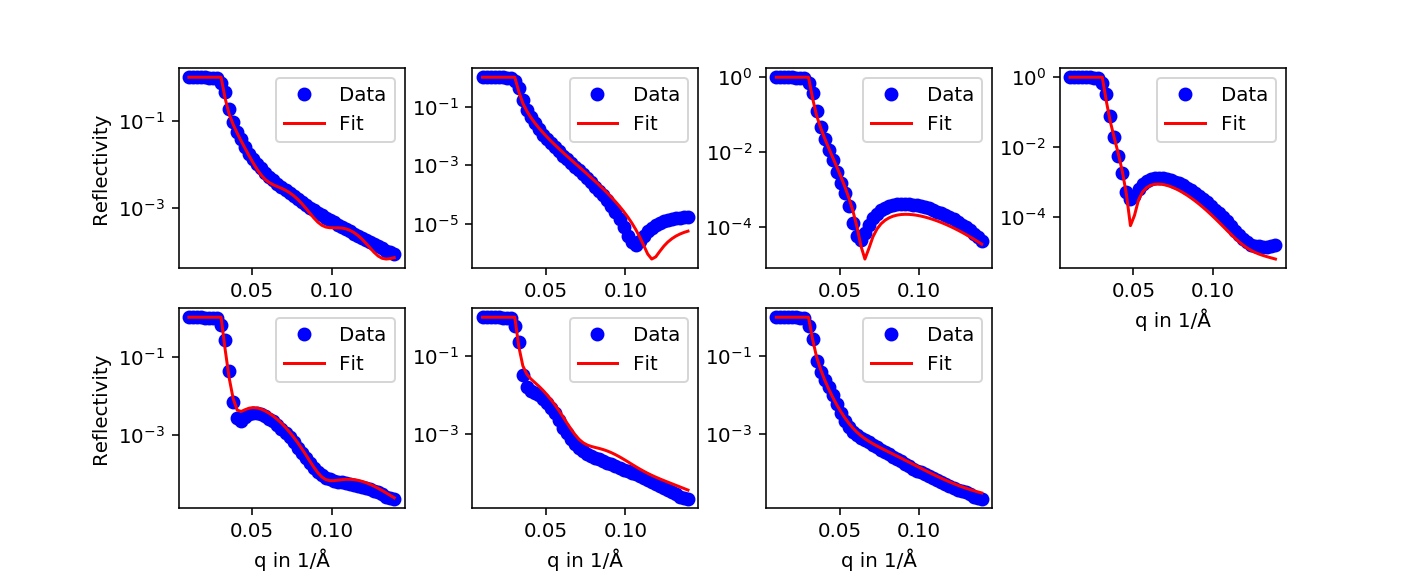

In [6]:
%matplotlib notebook
xrrplots.plot_reflectivity_gallery(
        q_vector, test_data, predicted_reflectivity[:, 1:], 10, output="show"
    )


<IPython.core.display.Javascript object>


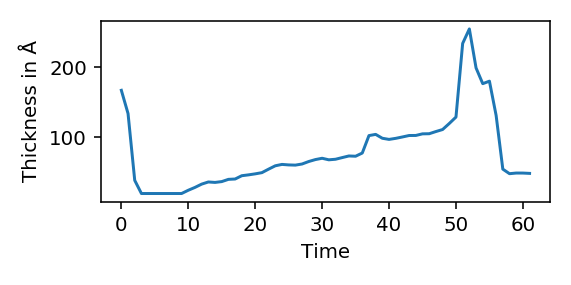

In [7]:
%matplotlib notebook
xrrplots.plot_thickness_vs_time(
        range(number_of_curves), thicknesses[:, 0], output="show"
    )


<IPython.core.display.Javascript object>


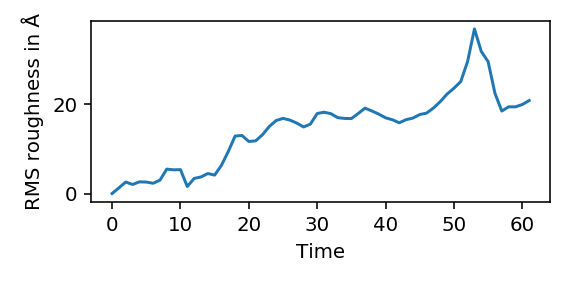

In [8]:
%matplotlib notebook
xrrplots.plot_roughness_vs_time(
        range(number_of_curves), roughnesses[:, 0], output="show"
    )

<IPython.core.display.Javascript object>


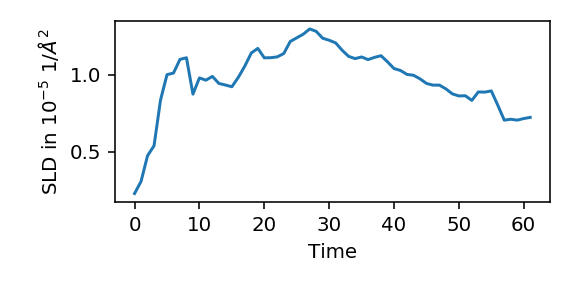

In [9]:
%matplotlib notebook
xrrplots.plot_SLD_vs_time(range(number_of_curves), SLDs[:, 0], output="show")